### L2X (learning to explain) on MNIST

This is an example of the L2X explainer on image classification. Different from gradient-based methods, L2X trains a separate explanation model. The advantage of L2X is that it generates explanations fast after the explanation model is trained. The disadvantage is that the quality of the explanations highly depend on the trained explanation model, which can be affected by multiple factors, e.g., the network structure of the explanation model, the training parameters.

For image data, we implement the default explanation model in `omnixai.explainers.vision.agnostic.l2x`. One may implement other models by following the same interface. Please refer to the docs for more details. If using this explainer, please cite the original work: "Learning to Explain: An Information-Theoretic Perspective on Model Interpretation, Jianbo Chen, Le Song, Martin J. Wainwright, Michael I. Jordan, https://arxiv.org/abs/1802.07814".

In [1]:
# This default renderer is used for sphinx docs only. Please delete this cell in IPython.
import plotly.io as pio
pio.renderers.default = "png"

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from omnixai.data.image import Image
from omnixai.explainers.vision import L2XImage

The model is a simple convolutional neural network with two convolutional layers and one dense hidden layer.

In [3]:
class InputData(Dataset):

    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index):
        return self.images[index], self.labels[index]
    

class MNISTNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        return x

The following code loads the training and test datasets. We recommend using `Image` to represent a batch of images. `Image` can be constructed from a numpy array or a Pillow image. In this example, `Image` is constructed from a numpy array containing a batch of digit images.

In [4]:
# Load the training and test datasets
train_data = torchvision.datasets.MNIST(root='../data', train=True, download=True)
test_data = torchvision.datasets.MNIST(root='../data', train=False, download=True)
train_data.data = train_data.data.numpy()
test_data.data = test_data.data.numpy()

class_names = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
# Use `Image` objects to represent the training and test datasets
train_imgs, train_labels = Image(train_data.data, batched=True), train_data.targets
test_imgs, test_labels = Image(test_data.data, batched=True), test_data.targets

The predictions function takes an `Image` instance as its input and outputs the class probabilities or logits for classification tasks.

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# The CNN model
model = MNISTNet().to(device)
# The preprocessing function
transform = transforms.Compose([transforms.ToTensor()])
preprocess = lambda ims: torch.stack([transform(im.to_pil()) for im in ims])
# The prediction function
predict_function = lambda ims: model(preprocess(ims).to(device)).detach().cpu().numpy()

We now train the CNN model defined above and evaluate its performance.

In [6]:
learning_rate=1e-3
batch_size=32
num_epochs=5

train_loader = DataLoader(
    dataset=InputData(preprocess(train_imgs), train_labels),
    batch_size=batch_size,
    shuffle=True
)
test_loader = DataLoader(
    dataset=InputData(preprocess(test_imgs), test_labels),
    batch_size=batch_size,
    shuffle=False
)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()

model.train()
for epoch in range(num_epochs):
    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        loss = loss_func(model(x), y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

correct_pred = {name: 0 for name in class_names}
total_pred = {name: 0 for name in class_names}

model.eval()
for x, y in test_loader:
    images, labels = x.to(device), y.to(device)
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)
    for label, prediction in zip(labels, predictions):
        if label == prediction:
            correct_pred[class_names[label]] += 1
        total_pred[class_names[label]] += 1

for name, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[name]
    print("Accuracy for class {} is: {:.1f} %".format(name, accuracy))

Accuracy for class 0 is: 99.6 %
Accuracy for class 1 is: 99.7 %
Accuracy for class 2 is: 98.8 %
Accuracy for class 3 is: 98.5 %
Accuracy for class 4 is: 99.4 %
Accuracy for class 5 is: 99.1 %
Accuracy for class 6 is: 98.4 %
Accuracy for class 7 is: 99.4 %
Accuracy for class 8 is: 98.7 %
Accuracy for class 9 is: 96.4 %


To initialize `L2XImage`, we need to set the following parameters:
  
  - `training_data`: The data used to train the explainer. `training_data` should be the training dataset for training the machine learning model.
  - `predict_function`: The prediction function corresponding to the model to explain. When the model is for classification, the outputs of the `predict_function` are the class probabilities. When the model is for regression, the outputs of the `predict_function` are the estimated values.
  - `mode`: The task type, e.g., `classification` or `regression`.
  - `selection_model`: A pytorch model class for estimating P(S|X) in L2X. If `selection_model = None`, a default model `DefaultSelectionModel` will be used.
  - `prediction_model`: A pytorch model class for estimating Q(X_S) in L2X. If `prediction_model = None`, a default model `DefaultPredictionModel` will be used.

In [7]:
explainer = L2XImage(
    training_data=train_imgs,
    predict_function=predict_function,
)

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


 |████████████████████████████████████████| 100.0% Complete, Loss 0.2665
L2X prediction model accuracy: 0.8901166666666667


We call `explainer.explain` to generate explanations for this classification task. `ipython_plot` plots the generated explanations in IPython. Parameter `index` indicates which instance to plot, e.g., `index = 0` means plotting the first instance in `test_imgs[0:5]`.

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


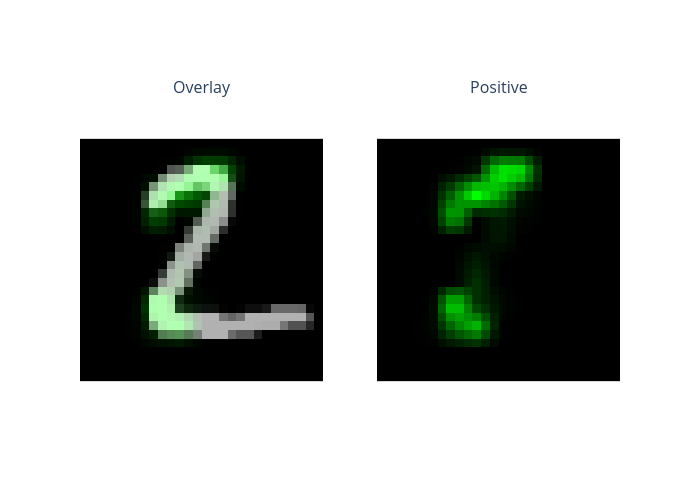

In [8]:
explanations = explainer.explain(test_imgs[0:5])
explanations.ipython_plot(index=1)